<a href="https://colab.research.google.com/github/dekinhitsuji/FDUA/blob/main/note1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install lightgbm==3.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [ ]:
import os
import re
import statistics


import datetime
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder

from time import time

%matplotlib inline
plt.style.use('seaborn-darkgrid')
import warnings
warnings.simplefilter('ignore')

<ipython-input-2-d31143136a58>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [ ]:
PATH = "/content/drive/MyDrive/FDUA"

for p in glob(os.path.join(PATH, "*")):
    print(p)
def read_csv(name, **kwrgs):
    path = os.path.join(PATH, name + ".csv")
    print(f"Load: {path}")
    return pd.read_csv(path, **kwrgs)
train_df = read_csv("train",  index_col='Unnamed: 0')
test_df = read_csv("test",  index_col='Unnamed: 0')


submit_df = read_csv("sample_submission")

/content/drive/MyDrive/FDUA/train.csv
/content/drive/MyDrive/FDUA/test.csv
/content/drive/MyDrive/FDUA/sample_submission.csv
/content/drive/MyDrive/FDUA/note1.ipynb
Load: /content/drive/MyDrive/FDUA/train.csv
Load: /content/drive/MyDrive/FDUA/test.csv
Load: /content/drive/MyDrive/FDUA/sample_submission.csv


In [ ]:
import seaborn as sns
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:80]

    fig, ax = plt.subplots(figsize=(15, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

In [ ]:
train_df

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,163,21,1.0,0,0,1,N,N,31-Jan-98,1,0,22-Sep-06,2006,PHOENIX,AZ,SD,"$80,000.00","$80,000.00","$68,000.00",0
1,84,6,1.0,4,0,0,0,N,31-Oct-93,1,62,30-Jun-92,1992,MCALESTER,OK,OK,"$287,000.00","$287,000.00","$229,600.00",0
2,242,45,1.0,4,90,0,N,N,31-Aug-01,1,42,18-Apr-01,2001,HAWTHORNE,NJ,NJ,"$31,983.00","$30,000.00","$15,000.00",1
3,237,4,1.0,0,0,0,N,N,31-Aug-07,1,33,6-Oct-03,2004,NASHVILLE,TN,SD,"$229,000.00","$229,000.00","$229,000.00",0
4,184,0,1.0,0,0,0,N,N,8-Jun-83,1,0,17-Dec-99,2000,POMONA,CA,CA,"$525,000.00","$525,000.00","$393,750.00",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,283,14,1.0,0,0,1,N,N,31-Jan-98,1,0,2-Mar-95,1995,PHILADELPHIA,PA,PA,"$80,000.00","$80,000.00","$68,000.00",0
42303,53,2,1.0,0,0,0,Y,N,3-Apr-91,1,42,6-Jun-07,2007,LOS ANGELES,CA,SD,"$5,000.00","$5,000.00","$4,250.00",1
42304,59,6,2.0,0,0,1,N,N,28-Feb-03,1,42,14-Mar-03,2003,COLUMBUS,OH,OH,"$60,000.00","$60,000.00","$51,000.00",0
42305,295,18,1.0,0,8,0,N,N,10-Dec-97,1,42,23-Aug-89,1989,CLOQUET,MN,MN,"$294,000.00","$294,000.00","$220,500.00",0


In [ ]:
test_df

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
42307,5,2,1.0,1,0,0,T,N,31-Jul-04,23,6-Aug-07,2007,SUNNYVALE,CA,CA,"$25,000.00","$25,000.00","$21,250.00",1
42308,235,13,1.0,9,14,77725,Y,N,11-Jan-95,44,8-Mar-04,2004,PITTSBURGH,PA,PA,"$15,000.00","$15,000.00","$7,500.00",0
42309,31,5,2.0,0,0,0,N,NaN,NaN,56,27-Feb-07,2007,LITTLE ROCK,AR,AR,"$28,000.00","$28,000.00","$23,800.00",1
42310,120,4,1.0,0,1,0,Y,N,30-Apr-99,62,19-Dec-97,1998,LITTLE ROCK,AR,AR,"$7,500.00","$7,500.00","$6,375.00",2
42311,63,13,1.0,0,8,1,N,N,31-Dec-05,42,10-Jul-09,2009,Louisville,KY,DE,"$91,000.00","$93,000.00","$93,000.00",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84610,243,10,1.0,3,14,0,N,N,1-Dec-12,42,23-Apr-12,2012,FT. WRIGHT,KY,OH,"$390,000.00","$150,000.00","$127,500.00",0
84611,178,0,2.0,0,0,1,N,N,30-Nov-03,0,27-Oct-06,2007,PHILADELPHIA,PA,RI,"$100,000.00","$100,000.00","$90,000.00",0
84612,42,1,2.0,3,9,0,Y,N,28-Feb-09,33,21-Sep-89,1989,ELMHURST,IL,IL,"$17,000.00","$17,000.00","$13,600.00",0
84613,76,15,1.0,0,0,0,N,N,31-Jan-08,0,3-Apr-06,2006,NASHVILLE,TN,TN,"$7,500.00","$7,500.00","$6,375.00",0


In [ ]:
all_df = pd.concat([train_df,test_df]).reset_index(drop=True)
all_df

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,163,21,1.0,0,0,1,N,N,31-Jan-98,1.0,0,22-Sep-06,2006,PHOENIX,AZ,SD,"$80,000.00","$80,000.00","$68,000.00",0
1,84,6,1.0,4,0,0,0,N,31-Oct-93,1.0,62,30-Jun-92,1992,MCALESTER,OK,OK,"$287,000.00","$287,000.00","$229,600.00",0
2,242,45,1.0,4,90,0,N,N,31-Aug-01,1.0,42,18-Apr-01,2001,HAWTHORNE,NJ,NJ,"$31,983.00","$30,000.00","$15,000.00",1
3,237,4,1.0,0,0,0,N,N,31-Aug-07,1.0,33,6-Oct-03,2004,NASHVILLE,TN,SD,"$229,000.00","$229,000.00","$229,000.00",0
4,184,0,1.0,0,0,0,N,N,8-Jun-83,1.0,0,17-Dec-99,2000,POMONA,CA,CA,"$525,000.00","$525,000.00","$393,750.00",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84610,243,10,1.0,3,14,0,N,N,1-Dec-12,NaN,42,23-Apr-12,2012,FT. WRIGHT,KY,OH,"$390,000.00","$150,000.00","$127,500.00",0
84611,178,0,2.0,0,0,1,N,N,30-Nov-03,NaN,0,27-Oct-06,2007,PHILADELPHIA,PA,RI,"$100,000.00","$100,000.00","$90,000.00",0
84612,42,1,2.0,3,9,0,Y,N,28-Feb-09,NaN,33,21-Sep-89,1989,ELMHURST,IL,IL,"$17,000.00","$17,000.00","$13,600.00",0
84613,76,15,1.0,0,0,0,N,N,31-Jan-08,NaN,0,3-Apr-06,2006,NASHVILLE,TN,TN,"$7,500.00","$7,500.00","$6,375.00",0


In [ ]:
all_df['DisbursementDate'] = pd.to_datetime(all_df['DisbursementDate'], format='%d-%b-%y', dayfirst=True)
all_df['ApprovalDate'] = pd.to_datetime(all_df['ApprovalDate'], format='%d-%b-%y', dayfirst=True)

In [ ]:
all_df

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,163,21,1.0,0,0,1,N,N,1998-01-31,1.0,0,2006-09-22,2006,PHOENIX,AZ,SD,"$80,000.00","$80,000.00","$68,000.00",0
1,84,6,1.0,4,0,0,0,N,1993-10-31,1.0,62,1992-06-30,1992,MCALESTER,OK,OK,"$287,000.00","$287,000.00","$229,600.00",0
2,242,45,1.0,4,90,0,N,N,2001-08-31,1.0,42,2001-04-18,2001,HAWTHORNE,NJ,NJ,"$31,983.00","$30,000.00","$15,000.00",1
3,237,4,1.0,0,0,0,N,N,2007-08-31,1.0,33,2003-10-06,2004,NASHVILLE,TN,SD,"$229,000.00","$229,000.00","$229,000.00",0
4,184,0,1.0,0,0,0,N,N,1983-06-08,1.0,0,1999-12-17,2000,POMONA,CA,CA,"$525,000.00","$525,000.00","$393,750.00",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84610,243,10,1.0,3,14,0,N,N,2012-12-01,NaN,42,2012-04-23,2012,FT. WRIGHT,KY,OH,"$390,000.00","$150,000.00","$127,500.00",0
84611,178,0,2.0,0,0,1,N,N,2003-11-30,NaN,0,2006-10-27,2007,PHILADELPHIA,PA,RI,"$100,000.00","$100,000.00","$90,000.00",0
84612,42,1,2.0,3,9,0,Y,N,2009-02-28,NaN,33,1989-09-21,1989,ELMHURST,IL,IL,"$17,000.00","$17,000.00","$13,600.00",0
84613,76,15,1.0,0,0,0,N,N,2008-01-31,NaN,0,2006-04-03,2006,NASHVILLE,TN,TN,"$7,500.00","$7,500.00","$6,375.00",0


In [ ]:
dol_col = ['DisbursementGross','GrAppv','SBA_Appv']

In [ ]:
dol_col = ['DisbursementGross','GrAppv','SBA_Appv']
all_df[dol_col] = all_df[dol_col].replace('[\$,]', '', regex=True).astype(float)

In [ ]:
all_df['RevLineCr'].value_counts()

N    55447
Y    14807
0    10907
T     1334
Name: RevLineCr, dtype: int64

In [ ]:
all_df['LowDoc'].value_counts()

N    68673
Y    10552
0     1359
A     1131
S     1063
C      786
Name: LowDoc, dtype: int64

In [ ]:
all_df['City'].value_counts()

HOUSTON           2378
PITTSBURGH        1864
SALT LAKE CITY    1269
NASHVILLE         1230
POMONA            1207
                  ... 
SALFORD              1
South Elgin          1
GLENNS FERRY         1
ATLANTIC             1
REPUBLIC             1
Name: City, Length: 3211, dtype: int64

In [ ]:
state_uni = all_df['State'].unique()

In [ ]:
bankstate_uni = all_df['BankState'].unique()

In [ ]:
bankstate_uni
state_dic = {}
for i,bankstate in enumerate(bankstate_uni):
  state_dic[bankstate] = i
state_dic

{'SD': 0,
 'OK': 1,
 'NJ': 2,
 'CA': 3,
 'IA': 4,
 'NH': 5,
 'ND': 6,
 'AZ': 7,
 'RI': 8,
 'UT': 9,
 'WI': 10,
 'DE': 11,
 'WY': 12,
 'NC': 13,
 'OH': 14,
 'IL': 15,
 'MD': 16,
 'CT': 17,
 'TN': 18,
 'PA': 19,
 'IN': 20,
 'VA': 21,
 'ME': 22,
 'NY': 23,
 'AL': 24,
 'VT': 25,
 'MT': 26,
 'MO': 27,
 'MN': 28,
 'NE': 29,
 'DC': 30,
 'TX': 31,
 'MI': 32,
 'KY': 33,
 'CO': 34,
 'OR': 35,
 'KS': 36,
 'FL': 37,
 'WA': 38,
 'LA': 39,
 'MA': 40,
 'GA': 41,
 'ID': 42,
 'NV': 43,
 'AR': 44,
 'AK': 45,
 'WV': 46,
 'MS': 47,
 'SC': 48,
 'HI': 49,
 'NM': 50,
 nan: 51,
 'PR': 52}

In [ ]:
all_df['BankState'] = all_df['BankState'].replace(state_dic)

In [ ]:
all_df['State'] = all_df['State'].replace(state_dic)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
all_df['City'] = label_encoder.fit_transform(all_df['City'])
all_df['RevLineCr'] = label_encoder.fit_transform(all_df['RevLineCr']) #変える
all_df['LowDoc'] = label_encoder.fit_transform(all_df['LowDoc']) #変える

In [ ]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84615 entries, 0 to 84614
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Term               84615 non-null  int64         
 1   NoEmp              84615 non-null  int64         
 2   NewExist           84615 non-null  float64       
 3   CreateJob          84615 non-null  int64         
 4   RetainedJob        84615 non-null  int64         
 5   FranchiseCode      84615 non-null  int64         
 6   RevLineCr          84615 non-null  int64         
 7   LowDoc             84615 non-null  int64         
 8   DisbursementDate   84305 non-null  datetime64[ns]
 9   MIS_Status         42307 non-null  float64       
 10  Sector             84615 non-null  int64         
 11  ApprovalDate       84615 non-null  datetime64[ns]
 12  ApprovalFY         84615 non-null  int64         
 13  City               84615 non-null  int64         
 14  State 

In [ ]:
all_df

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,163,21,1.0,0,0,1,1,3,1998-01-31,1.0,0,2006-09-22,2006,2208,7,0,80000.0,80000.0,68000.0,0
1,84,6,1.0,4,0,0,0,3,1993-10-31,1.0,62,1992-06-30,1992,1723,1,1,287000.0,287000.0,229600.0,0
2,242,45,1.0,4,90,0,1,3,2001-08-31,1.0,42,2001-04-18,2001,1214,2,2,31983.0,30000.0,15000.0,1
3,237,4,1.0,0,0,0,1,3,2007-08-31,1.0,33,2003-10-06,2004,1906,18,0,229000.0,229000.0,229000.0,0
4,184,0,1.0,0,0,0,1,3,1983-06-08,1.0,0,1999-12-17,2000,2246,3,3,525000.0,525000.0,393750.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84610,243,10,1.0,3,14,0,1,3,2012-12-01,NaN,42,2012-04-23,2012,1022,33,14,390000.0,150000.0,127500.0,0
84611,178,0,2.0,0,0,1,1,3,2003-11-30,NaN,0,2006-10-27,2007,2207,19,8,100000.0,100000.0,90000.0,0
84612,42,1,2.0,3,9,0,3,3,2009-02-28,NaN,33,1989-09-21,1989,858,15,15,17000.0,17000.0,13600.0,0
84613,76,15,1.0,0,0,0,1,3,2008-01-31,NaN,0,2006-04-03,2006,1906,18,18,7500.0,7500.0,6375.0,0


In [ ]:
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

#main

In [ ]:
train = all_df[~pd.isnull(all_df['MIS_Status'])]
test = all_df[pd.isnull(all_df['MIS_Status'])]

In [ ]:
drop_col = ['MIS_Status','DisbursementDate','ApprovalDate']

In [ ]:
x = train.drop(drop_col,axis=1).values
y = train['MIS_Status'].values

In [ ]:
x

array([[1.6300e+02, 2.1000e+01, 1.0000e+00, ..., 8.0000e+04, 6.8000e+04,
        0.0000e+00],
       [8.4000e+01, 6.0000e+00, 1.0000e+00, ..., 2.8700e+05, 2.2960e+05,
        0.0000e+00],
       [2.4200e+02, 4.5000e+01, 1.0000e+00, ..., 3.0000e+04, 1.5000e+04,
        1.0000e+00],
       ...,
       [5.9000e+01, 6.0000e+00, 2.0000e+00, ..., 6.0000e+04, 5.1000e+04,
        0.0000e+00],
       [2.9500e+02, 1.8000e+01, 1.0000e+00, ..., 2.9400e+05, 2.2050e+05,
        0.0000e+00],
       [8.4000e+01, 4.0000e+00, 1.0000e+00, ..., 6.7500e+04, 5.0625e+04,
        0.0000e+00]])

In [ ]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True,random_state=18)
cv = []
for train_index, test_index in kf.split(x, y):
  cv.append([train_index, test_index])

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
import lightgbm as lgbm

def fit_lgbc(X,
             y,
             cv,
             params: dict=None,
             verbose: int=1000):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix="fit fold={} ".format(i)):
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = roc_auc_score(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    #score = roc_auc_score(y, oof_pred)
    print("=" * 50)
    best_score=0
    best_threshold=0.5
    for thresholds in np.arange(0.6, 0.83, 0.001):
      score =  f1_score(y, oof_pred>thresholds, average='macro')
      if best_score<score:
        best_score = score
        best_threshold = thresholds
    print(f"FINISHI:  best_score={best_score:.4f}    best_threshold={best_threshold:.4f}")
    return score, oof_pred, models

In [ ]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します.
    "objective": "binary",
    "metrics":"auc",
    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    "n_estimators": 10000,

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    "learning_rate": .1,
    "max_depth": 5,
    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain",
    "random_state": 71,
}

In [ ]:
score, oof, models = fit_lgbc(X=x,
                              y=y,
                              cv=cv,
                              params=params)

fit fold=0  0.979[s]
 - fold1 - 0.7732
fit fold=1  1.235[s]
 - fold2 - 0.7708
fit fold=2  3.435[s]
 - fold3 - 0.7651
fit fold=3  1.078[s]
 - fold4 - 0.7846
fit fold=4  0.912[s]
 - fold5 - 0.7910
FINISHI:  best_score=0.6767    best_threshold=0.7590


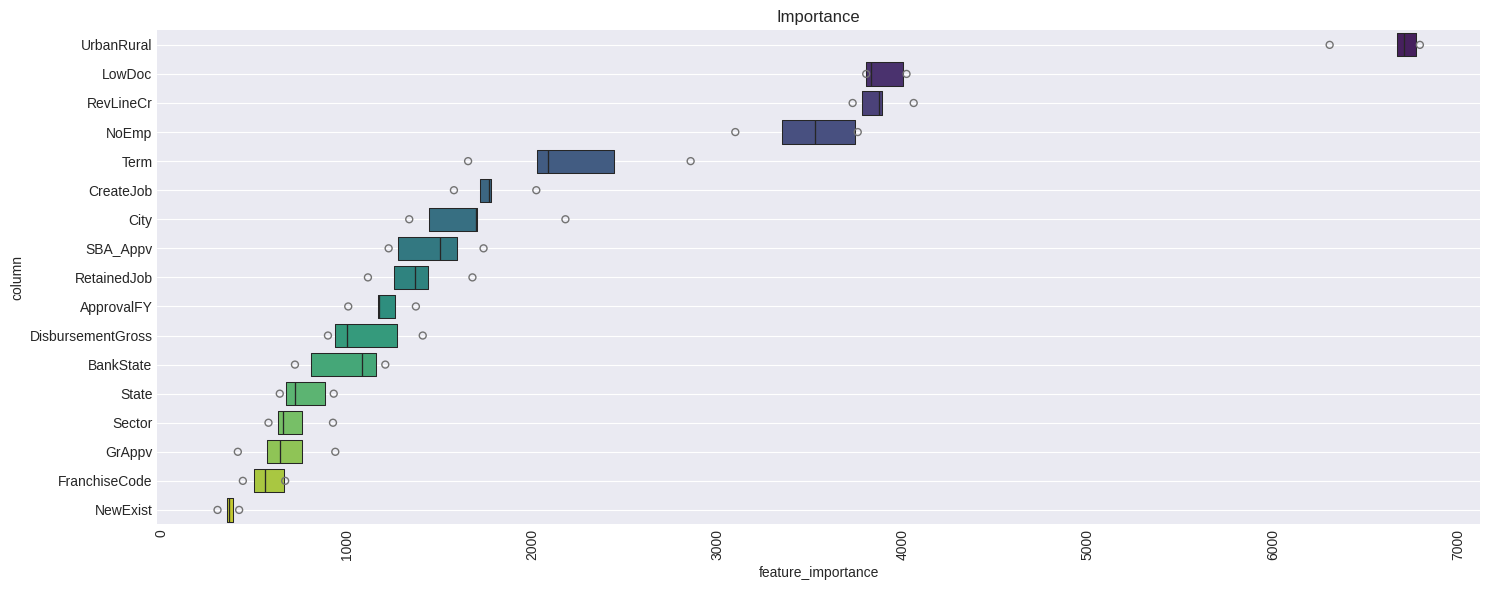

In [ ]:
fig, ax, BaseModelImportance = visualize_importance(models, train_df.drop(drop_col, axis = 1))

In [ ]:
test_data = test.drop(drop_col,axis=1).values

In [ ]:
pred_score = np.array([model.predict_proba(test_data) for model in models])

In [ ]:
print(f"1. shape: {pred_score.shape}")

1. shape: (5, 42308, 2)


In [ ]:
# k 個のモデルの平均を計算
pred_score = np.mean(pred_score, axis = 0)# axis=0 なので shape の `k` が潰れる
print(f"2. shape: {pred_score.shape}")

2. shape: (42308, 2)


In [ ]:
pred_score

array([[0.74522044, 0.25477956],
       [0.0367829 , 0.9632171 ],
       [0.36876269, 0.63123731],
       ...,
       [0.07546672, 0.92453328],
       [0.0863281 , 0.9136719 ],
       [0.69709986, 0.30290014]])

In [ ]:
submit_df = pd.DataFrame({"ID": range(42307, 84615), "prob": pred_score[:, 1], "pred":(pred_score[:, 1]>0.7590)*1})
submit_df

,ID,prob,pred
0,42307,0.254780,0
1,42308,0.963217,1
2,42309,0.631237,0
3,42310,0.841570,1
4,42311,0.967484,1
...,...,...,...
42303,84610,0.974247,1
42304,84611,0.943994,1
42305,84612,0.924533,1
42306,84613,0.913672,1


In [ ]:
submit_df.pred.value_counts()

1    38965
0     3343
Name: pred, dtype: int64

In [ ]:
submit_df[["ID", "pred"]].to_csv("base1.csv", index=None, header=None)